In [1]:
import os
import sys
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from Utils import gdalCommonUtils as gutils
from Utils import IO as io
from Utils import tileHelpers as tileHelper

In [3]:
import tensorflow as tf
from tensorflow.keras import models
from osgeo import gdal, ogr, osr
import cv2 

In [4]:
print('TF Version -->', tf.__version__)
print('GDAL Version -->', gdal.__version__)
print('OPEN CV Version -->', cv2.__version__)

TF Version --> 1.15.0
GDAL Version --> 2.3.2
OPEN CV Version --> 4.2.0


In [5]:
print('CURRENT WORKING DIR -->', os.getcwd())

CURRENT WORKING DIR --> D:\Nikhil\Paper-4-gitHub\LS_Mapping


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
PROJECT_PATH = '.'
OUTPUT_PATH  = os.path.join(*[PROJECT_PATH, 'Mapping_results'])

io.createDirectory(OUTPUT_PATH, emptyExistingFiles = True, verbose = True)

.\Mapping_results --> Folder exists!!!
1 files found in .\Mapping_results --> Will be deleted.


In [8]:
BASE_RESOLUTION = 6

SAVED_MODEL = os.path.join(*[PROJECT_PATH, 'M_ALL_006.hdf5'])


RAW_DATA_PATH = os.path.join(*[PROJECT_PATH, 'RawData', 'AOI_E_S2-S2'])

DEM_PATH   = os.path.join(*[RAW_DATA_PATH, 'DEM', 'DEM_030.tif'])
HS_PATH    = os.path.join(*[RAW_DATA_PATH, 'DEM', 'DEM_030_HILLSHADE.tif'])
SLOPE_PATH = os.path.join(*[RAW_DATA_PATH, 'DEM', 'DEM_030_SLOPE.tif'])

POST_IMAGE_PATH = os.path.join(*[RAW_DATA_PATH, 'fromOptical',  'JIUZ_POST_S2_RGB_010_UINT8.tif'])
PRE_IMAGE_PATH  = os.path.join(*[RAW_DATA_PATH, 'fromOptical',  'JIUZ_PRE_S2_RGB_010_UINT8.tif'])
NO_DATA_MASK    = os.path.join(*[RAW_DATA_PATH, 'noDataMask',   'SNOW_CLOUD_MASK_010.tif'])

In [9]:
assert os.path.isfile(SAVED_MODEL)

assert os.path.isfile(DEM_PATH)
assert os.path.isfile(HS_PATH)
assert os.path.isfile(SLOPE_PATH)

assert os.path.isfile(POST_IMAGE_PATH)
assert os.path.isfile(PRE_IMAGE_PATH)

TEST_ROI_PATH   = os.path.join(*[RAW_DATA_PATH, 'testBoundary', 'Test_%s.tif'%str(BASE_RESOLUTION).zfill(3)])
assert os.path.isfile(TEST_ROI_PATH)

In [10]:
def open_and_rescale_to_baseResolution(img_path, shape, crop_to_bbox=None):
    img = gutils.readGDAL2numpy(img_path)
    img = tileHelper.rescaleInput(img, shape)
    if crop_to_bbox is not None:
        yMin, yMax, xMin, xMax = bbox
        img = img[yMin: yMax, xMin: xMax]
    return img

In [11]:
bbox, binaryMask, newGeoT, proj = gutils.getBoundingBox(rasterPath = TEST_ROI_PATH, returnBinaryMask = True)
nscn, npix = binaryMask.shape


## generate a mask from no data file
if os.path.isfile(NO_DATA_MASK):
    maskImage = 1 - open_and_rescale_to_baseResolution(img_path=NO_DATA_MASK, shape=(nscn, npix), crop_to_bbox=bbox)
else:
    maskImage = np.zeros(shape=(nscn, npix))

    
## append in mask file where test area Image == 0
maskImage[binaryMask == 0] = 0

maskFileName = os.path.join(*[OUTPUT_PATH, 'MaskImage.tif'])
gutils.writeNumpyArr2Geotiff(maskFileName, 1-maskImage, newGeoT, proj, GDAL_dtype=gdal.GDT_Byte, noDataValue=0)


In [12]:
imageSize = 224
overlapFactor = 2
fetchSize = int(imageSize / 2)
skipPx = int(imageSize / overlapFactor)

## Generates all possible bounding boxes for tiling
## The center location of every box is the anchor point defined in list 'locXY'
Y = [y for y in range(fetchSize + 1, nscn - fetchSize - 1, skipPx)]
X = [x for x in range(fetchSize + 1, npix - fetchSize - 1, skipPx)]
locXY = list(itertools.product(X, Y))

## extract all the valid boxes
## i.e. which are in the study area and landslide mask
## Mask Image == 1 for valid regions
## threshold of 0.75 --> 75% region is valid
validLocXY = [currLoc for currLoc in locXY if tileHelper.isValidTile(maskImage, imageSize, currLoc, threshold=0.50)]

In [13]:
postImage = open_and_rescale_to_baseResolution(img_path=POST_IMAGE_PATH, shape=(nscn, npix), crop_to_bbox=bbox)
preImage  = open_and_rescale_to_baseResolution(img_path=PRE_IMAGE_PATH,  shape=(nscn, npix), crop_to_bbox=bbox)

hs    = open_and_rescale_to_baseResolution(img_path=HS_PATH,    shape=(nscn, npix), crop_to_bbox=bbox)
slope = open_and_rescale_to_baseResolution(img_path=SLOPE_PATH, shape=(nscn, npix), crop_to_bbox=bbox)

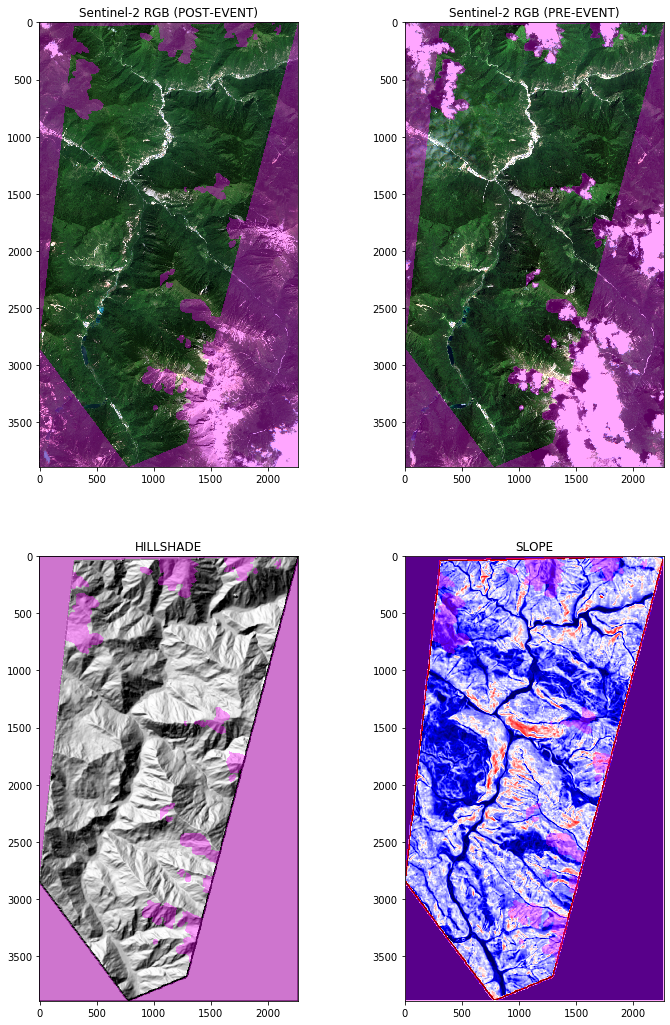

In [14]:
showMask = True

# display images
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,18)) 

ax[0,0].imshow(postImage)
ax[0,0].set_title('Sentinel-2 RGB (POST-EVENT)')

ax[0,1].imshow(preImage)
ax[0,1].set_title('Sentinel-2 RGB (PRE-EVENT)')

ax[1,0].imshow(hs, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('HILLSHADE')

ax[1,1].imshow(slope, cmap='seismic', vmin=0, vmax=90)
ax[1,1].set_title('SLOPE')

if showMask:
    maskForDisplay = 1 - maskImage.copy()
    maskForDisplay = np.float32(maskForDisplay)
    maskForDisplay[maskForDisplay == 0] = np.nan
    
    ax[0,0].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[0,1].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1,0].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1,1].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    
plt.show()

In [15]:
def normalize(image):
    new_img = np.array(image, dtype = np.float32)
    new_img /= 127.5
    new_img -= 1.
    return new_img
    

def normalizeArray(image):
    # post image
    image[ : , :, :3] = normalize(image[ : , :, :3])
    
    # pre image
    image[ : , :, 3:6] = normalize(image[ : , :, 3:6])

    # HS image
    image[ : , :, 6:7] = normalize(image[ : , :, 6:7])

    # Slope Image
    image[ : , :, -1] = (image[ : , :, -1] / 45.0) - 1.0
    
    return image

In [16]:
stack = []

stack.append(postImage)
stack.append(preImage)
stack.append(hs[:, :, np.newaxis])
stack.append(slope[:, :, np.newaxis])

testImage = np.concatenate(stack, axis=2)
del stack

testImage = np.nan_to_num(testImage)
testImage = normalizeArray(testImage)

inputChannel = testImage.shape[2]

predictMask = np.zeros((testImage.shape[0], testImage.shape[1]), np.uint8)

fetchSize_half = int(fetchSize/2)

In [17]:
model = models.load_model(SAVED_MODEL, compile=False)

model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
for x, y in tqdm(validLocXY):

    img = testImage[y - fetchSize: y + fetchSize, x - fetchSize: x + fetchSize, :]

    img = img.reshape(1, imageSize, imageSize, inputChannel)
    predict_image_list = [img[:, :, :, 3:6],  # pre-image
                          img[:, :, :, :3],  # post-image
                          img[:, :, :, -2:]  # topo-image
                            ]
    predicted_label = model.predict(predict_image_list)[0][0]

    predictMask[y - fetchSize_half: y + fetchSize_half, x - fetchSize_half: x +
        fetchSize_half] = predicted_label[fetchSize_half: -fetchSize_half, fetchSize_half: -fetchSize_half, 0] * 100

predictMask = predictMask * maskImage
gutils.writeNumpyArr2Geotiff(OUTPUT_PATH + '/Predict_LS_Conf.tif', predictMask, newGeoT, proj, GDAL_dtype= gdal.GDT_Byte, noDataValue = 0)

100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [00:17<00:00, 23.78it/s]


In [19]:
threshold = 50
predictMask_highConf = predictMask.copy()
predictMask_highConf[predictMask_highConf < threshold] = 0
predictMask_highConf[predictMask_highConf >= threshold] = 1

rasterPath = OUTPUT_PATH + '/Predict_LS_HighConf_{}.tif'.format(str(threshold))
gutils.writeNumpyArr2Geotiff(rasterPath, predictMask, newGeoT, proj, GDAL_dtype=gdal.GDT_Byte, noDataValue=0)

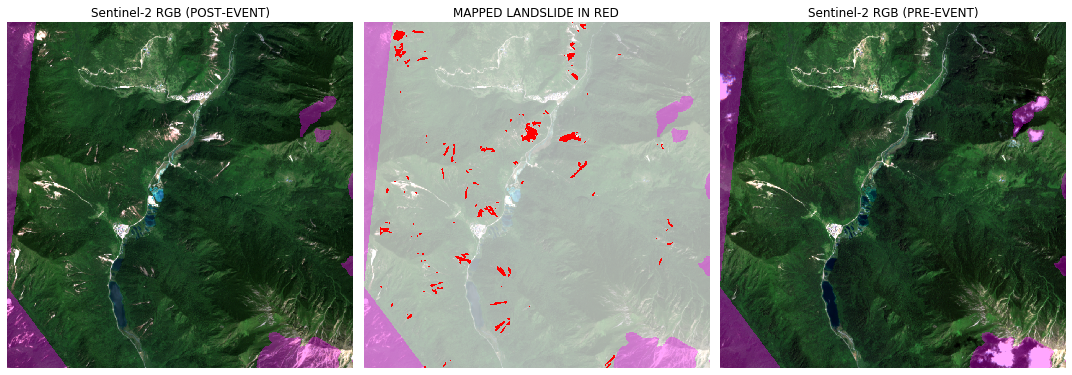

In [20]:
showMask = True

## Zoom to Extent
xmin, xmax = 0, 1250
ymin, ymax = -2000, -750


LSForDisplay = predictMask_highConf.copy()
LSForDisplay = np.float32(LSForDisplay)
LSForDisplay[LSForDisplay == 0] = np.nan


# display images
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15)) 

ax[0].imshow(postImage[ymin:ymax,xmin:xmax])
ax[0].set_title('Sentinel-2 RGB (POST-EVENT)')
ax[0].axis('off')

ax[1].imshow(postImage[ymin:ymax,xmin:xmax], alpha= 0.35)
ax[1].imshow(LSForDisplay[ymin:ymax,xmin:xmax], alpha=1, cmap='bwr', vmin=0, vmax=1)
ax[1].set_title('MAPPED LANDSLIDE IN RED')
ax[1].axis('off')

ax[2].imshow(preImage[ymin:ymax,xmin:xmax])
ax[2].set_title('Sentinel-2 RGB (PRE-EVENT)')
ax[2].axis('off')


if showMask:
    maskForDisplay = 1 - maskImage.copy()
    maskForDisplay = np.float32(maskForDisplay)
    maskForDisplay[maskForDisplay == 0] = np.nan
    
    ax[0].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[2].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)

fig.tight_layout()
plt.show()